# Example 1/f noise fitting

Many spin quantum-dot devices show 1/f noise. In this notebook we generate [1/f](https://en.wikipedia.org/wiki/Pink_noise) noise with a sine signal, analyse the signal by calculating the power [spectral density](https://en.wikipedia.org/wiki/Spectral_density) and finally fitting a 1/f noise model.

A common use case is to measure the signal of a charge sensor (converting the measured signal to physical units by measuring the slope and a lever-arm) and analyse the noise.

In [2]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
%matplotlib inline

from qtt.algorithms.noise_analysis import pink_noise_model, outlier_detection, calculate_psd_welch, plot_psd, generate_pink_noise, fit_pink_noise

First we generate a signal that consists of a sine-wave and 1/f noise.

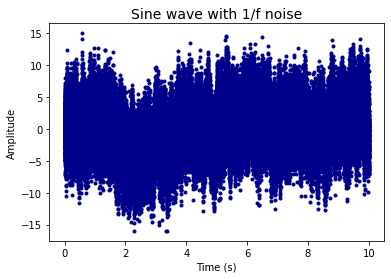

In [3]:
sample_rate=10e3
N = int(1e5)
amplitude = 2*np.sqrt(2)
sine_frequency = 1234.0
times = np.arange(N) / sample_rate

signal = generate_pink_noise(sample_rate, N, A=1)
signal += amplitude*np.sin(2*np.pi*sine_frequency*np.arange(N)/sample_rate)
signal_unit = 'ueV'

plt.plot(times, signal, '.', color = 'darkblue')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
_=plt.title('Sine wave with 1/f noise', fontsize = 14)

We calculate the power spectral density (PSD) using the Welch method. This method divides the data into segments, calculates the PSD for each segment and averages the results. The number of segments is a trade-off between noise reduction (more sections) and a higher sampling rate in frequency space (less sections).

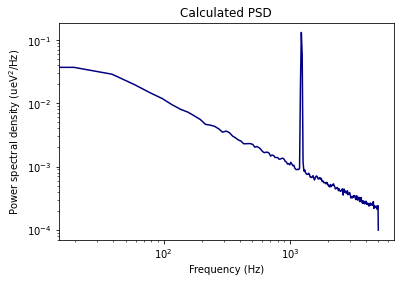

In [4]:
f_welch, P_welch = calculate_psd_welch(signal, sample_rate = sample_rate, nperseg = 512)
plot_psd(f_welch, P_welch, fig=2, label='PSD', signal_unit=signal_unit)
_=plt.title('Calculated PSD')

We fit the following model to the PSD:
$$S(f)=A / f^\alpha$$
To make the fitting robust against outliers and to reduce the effect of the sine component we add outlier detection.

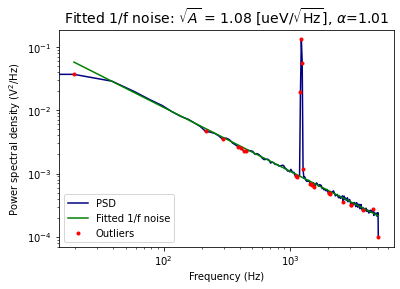

In [37]:
_,results=fit_pink_noise(x_data=f_welch, y_data=P_welch, remove_outliers=True)
inliers=results['inliers']

noise_fit=pink_noise_model(f_welch[1:], **results['fitted_parameter_dictionary'])
A=results['fitted_parameter_dictionary']['A']
alpha=results['fitted_parameter_dictionary']['alpha']

plot_psd(f_welch, P_welch, fig=2, label='PSD')
plt.plot(f_welch[1:], noise_fit, '-g', label='Fitted 1/f noise')
plt.plot(f_welch[1:][inliers==False], P_welch[1:][inliers==False], '.r', label='Outliers')
plt.title(f'Fitted 1/f noise: $\\sqrt{{A}}$ = {np.sqrt(A):.2f} [{signal_unit}/$\\sqrt{{\\mathrm{{ Hz }} }}$], $\\alpha$={alpha:.2f}', fontsize=14)
_=plt.legend()